# Structure-shift

We compare the following CSBMs and how their node2vec encoding changes:
- Constant CSBM
- CSBM-Hom
- CSBM-Het
- CSBM-Struct

We find the following assumptions useful:
- We compare nodes within the same embedding
- We compare the embeddings of the t-th chunk of nodes against the 1st chunk
- We use the same loader and optimizer for each epoch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from csbms import MultiClassCSBM, StructureCSBM
from CSBMhet import CSBMhet
from CSBMhom import CSBMhom
from metrics import mmd_linear

import torch
from torch_geometric.nn import Node2Vec

In [2]:
d = 128
n = 50
c = 16
training_time = 5
q1 = 0.05
q2 = 0.01
T = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
csbm_constant = MultiClassCSBM(n=n, dimensions=d, classes=c, q_hom=q1, q_het=q2)
csbm_hom = CSBMhom(n=n, dimensions=d, classes=c, q_hom=q1, q_het=q2)
csbm_het = CSBMhet(n=n, dimensions=d, classes=c, q_hom=q1, q_het=q2)
csbm_struct = StructureCSBM(n=n, dimensions=d, classes=c)
csbms = [csbm_constant, csbm_hom, csbm_het, csbm_struct]

In [4]:
time_steps = list(range(T))
for _ in range(T - 1):
    for csbm in csbms:
        csbm.evolve()

In [5]:
def get_node_embeddings(csbm):
    data = csbm.data
    model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0).to(device)
    
    num_workers = 4 if sys.platform == 'linux' else 0
    loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
    optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01)
    
    def train():
        model.train()
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)
    
    @torch.no_grad()
    def test():
        model.eval()
        z = model()
        acc = model.test(
            train_z=z[data.train_mask],
            train_y=data.y[data.train_mask],
            test_z=z[data.test_mask],
            test_y=data.y[data.test_mask],
            max_iter=150,
        )
        return acc
    
    for epoch in range(training_time):
        loss = train()
        acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')
    return model.embedding.weight.cpu().detach().numpy()

In [6]:
embeddings = []
for csbm in csbms:
    embeddings.append(get_node_embeddings(csbm))
emb_const, emb_hom, emb_het, emb_struct = embeddings

Epoch: 000, Loss: 6.4801, Acc: 0.7889
Epoch: 001, Loss: 5.9681, Acc: 0.7889
Epoch: 002, Loss: 5.5848, Acc: 0.7889
Epoch: 003, Loss: 5.2662, Acc: 0.7889
Epoch: 004, Loss: 4.9862, Acc: 0.7889
Epoch: 000, Loss: 6.5535, Acc: 0.7933
Epoch: 001, Loss: 6.0840, Acc: 0.7956
Epoch: 002, Loss: 5.6564, Acc: 0.7956
Epoch: 003, Loss: 5.3473, Acc: 0.7956
Epoch: 004, Loss: 5.0924, Acc: 0.7956
Epoch: 000, Loss: 6.6552, Acc: 0.7867
Epoch: 001, Loss: 6.1670, Acc: 0.7867
Epoch: 002, Loss: 5.7815, Acc: 0.7867
Epoch: 003, Loss: 5.4608, Acc: 0.7867
Epoch: 004, Loss: 5.1930, Acc: 0.7911
Epoch: 000, Loss: 6.4280, Acc: 0.7911
Epoch: 001, Loss: 5.9672, Acc: 0.7911
Epoch: 002, Loss: 5.5778, Acc: 0.7911
Epoch: 003, Loss: 5.2152, Acc: 0.7911
Epoch: 004, Loss: 4.9285, Acc: 0.7889


In [7]:
def get_mmds(embedding):
    differences = []
    for t in range(T):
        start = t * n
        end = start + n
        differences.append(mmd_linear(embedding[:n], embedding[start:end]))
    return differences

In [8]:
mmds_const = get_mmds(emb_const)
mmds_hom = get_mmds(emb_hom)
mmds_het = get_mmds(emb_het)
mmds_struct = get_mmds(emb_struct)

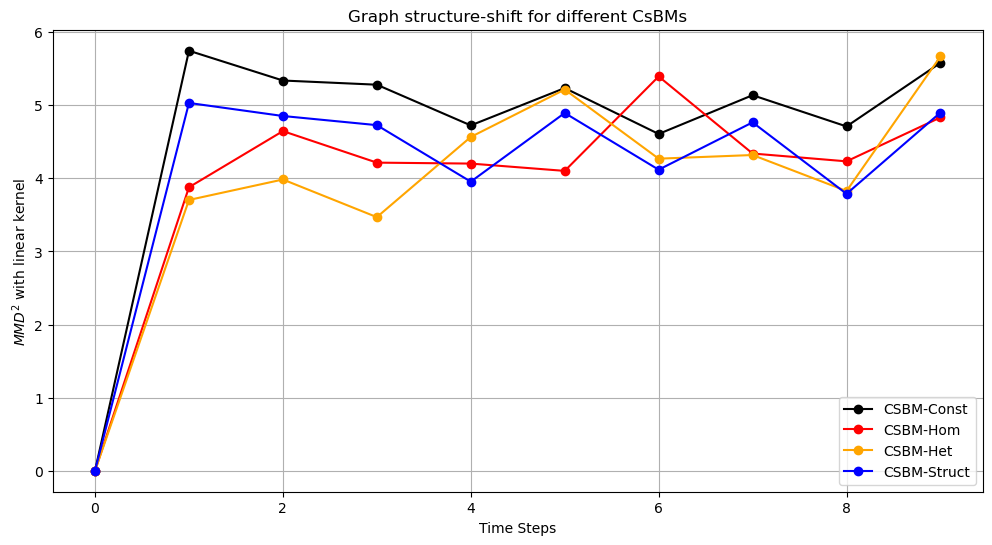

In [9]:
# plot
plt.figure(figsize=(12, 6))

plt.plot(time_steps, mmds_const, marker='o', linestyle='-', color='black', label='CSBM-Const')
plt.plot(time_steps, mmds_hom, marker='o', linestyle='-', color='r', label='CSBM-Hom')
plt.plot(time_steps, mmds_het, marker='o', linestyle='-', color='orange', label='CSBM-Het')
plt.plot(time_steps, mmds_struct, marker='o', linestyle='-', color='blue', label='CSBM-Struct')

plt.title(r'Graph structure-shift for different CSBMs')
plt.xlabel('Time Steps')
plt.ylabel(r'$MMD^{2}$ with linear kernel')
plt.grid(True)
plt.legend(loc='lower right')
plt.savefig('structure_shift_all.pdf', format='pdf')
plt.show()
plt.close()

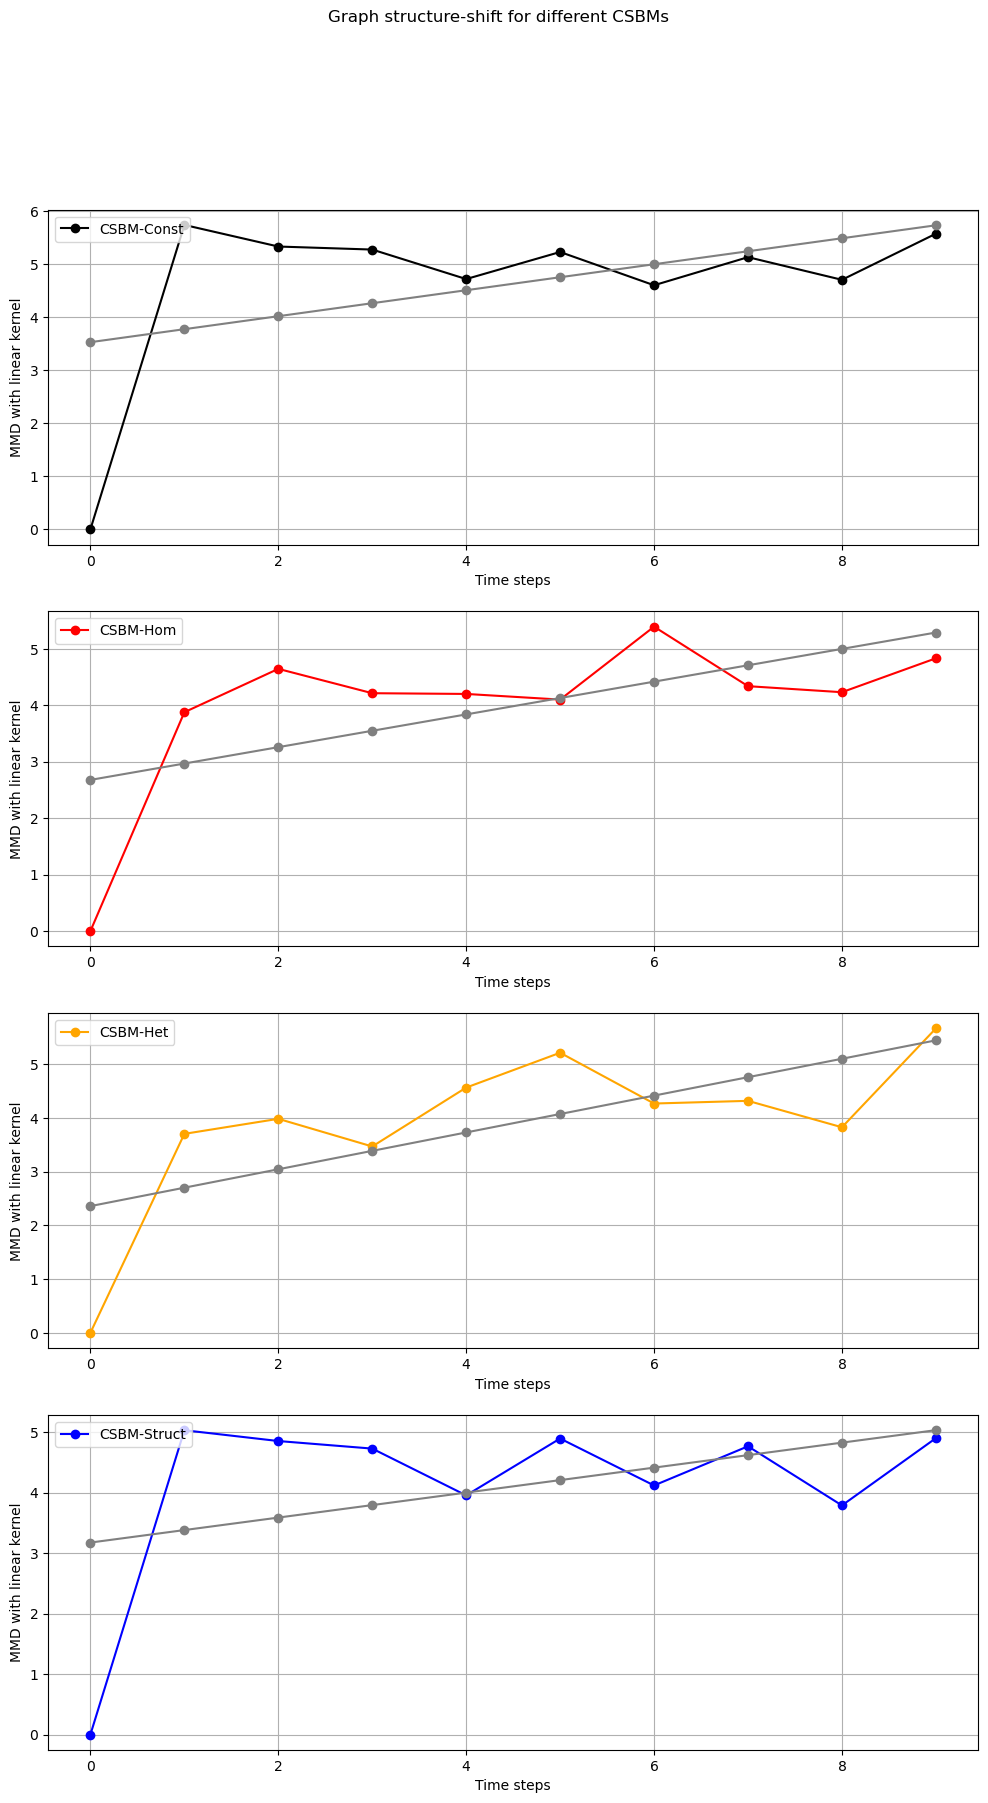

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 20))
fig.suptitle(r'Graph structure-shift for different CSBMs')

coefficiencts = np.polyfit(time_steps, mmds_const, 1)
poly = np.poly1d(coefficiencts)
y_fit = poly(time_steps)
axes[0].plot(time_steps, mmds_const, marker='o', linestyle='-', color='black', label='CSBM-Const')
axes[0].plot(time_steps, y_fit, marker='o', linestyle='-', color='gray')

coefficiencts = np.polyfit(time_steps, mmds_hom, 1)
poly = np.poly1d(coefficiencts)
y_fit = poly(time_steps)
axes[1].plot(time_steps, mmds_hom, marker='o', linestyle='-', color='red', label='CSBM-Hom')
axes[1].plot(time_steps, y_fit, marker='o', linestyle='-', color='gray')

coefficiencts = np.polyfit(time_steps, mmds_het, 1)
poly = np.poly1d(coefficiencts)
y_fit = poly(time_steps)
axes[2].plot(time_steps, mmds_het, marker='o', linestyle='-', color='orange', label='CSBM-Het')
axes[2].plot(time_steps, y_fit, marker='o', linestyle='-', color='gray')

coefficiencts = np.polyfit(time_steps, mmds_struct, 1)
poly = np.poly1d(coefficiencts)
y_fit = poly(time_steps)
axes[3].plot(time_steps, mmds_struct, marker='o', linestyle='-', color='b', label='CSBM-Struct')
axes[3].plot(time_steps, y_fit, marker='o', linestyle='-', color='gray')

for ax in axes:
    ax.set_xlabel('Time steps')
    ax.set_ylabel('MMD with linear kernel')
    ax.legend(loc='upper left')
    ax.grid(True)
plt.savefig('structure_shift_separate.pdf', format='pdf')
plt.show()
plt.close()

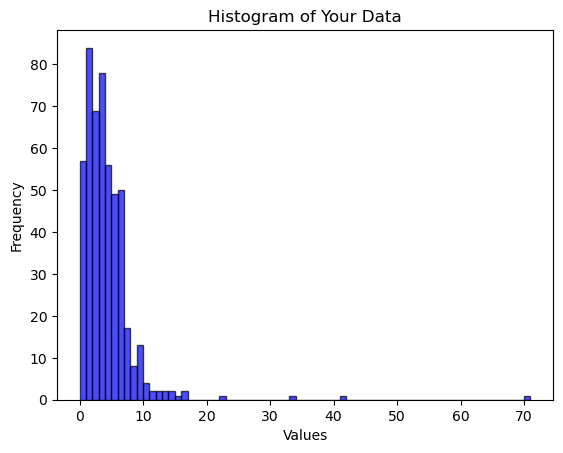

In [13]:
plt.hist(csbm_struct.node_degrees.values(), bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Your Data')
plt.savefig('csbm_struct_histogram.pdf', format='pdf')
plt.show()
plt.close()